In [1]:
import pandas as pd
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = ".\\DATA\\HAM10000_images_part_1_and_2"  # directory with all images

In [3]:
dest_dir = ".\\DATA\\recognized\\"  # directory where all images will be divided into subdirectories

In [4]:
df = pd.read_csv(".\\DATA\\HAM10000_metadata")  # read metadata

In [5]:
df = df.rename(columns={"dx": "diagnosis"})
df = df[["image_id", "diagnosis"]]

In [6]:
for label in df["diagnosis"].unique():
    os.makedirs(
        os.path.join(dest_dir, label), exist_ok=True
    )  # make directory for each label

In [7]:
for index, row in df.iterrows():
    source_file = os.path.join(data_dir, f"{row['image_id']}.jpg")
    destination_file = os.path.join(
        dest_dir, row["diagnosis"], f"{row['image_id']}.jpg"
    )
    shutil.copyfile(
        source_file, destination_file
    )  # copy image to defined earlier subdirectory

In [8]:
datagen = ImageDataGenerator()  # initialize ImageDataGenerator

In [9]:
images_data_keras = datagen.flow_from_directory(
    directory=dest_dir,
    class_mode="sparse",
    batch_size=16,
    target_size=(200, 150),
)  # load all images in 'rgb' format using batch approach

Found 10015 images belonging to 7 classes.


In [10]:
X = []
y = []
for i in range(len(images_data_keras)):
    images, labels = images_data_keras[i]
    X.extend(images)
    y.extend(labels)  # add images to X and labels to y

In [11]:
X = np.array(X)

In [12]:
X = [image.flatten() for image in X]  # change np.array's dimension into one

In [13]:
X = np.array(X)  # ensure that X is stored as np.array

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)  # divide data into train and test

In [15]:
scaler = StandardScaler()  # create StandardScaler instance

In [16]:
X_train_scaled = scaler.fit_transform(X_train)

In [17]:
X_test_scaled = scaler.transform(X_test)

In [18]:
pca = PCA()  # create PCA instance

In [19]:
pca.fit(X_train)  # fit to X_train in order to choose number of components

PCA()

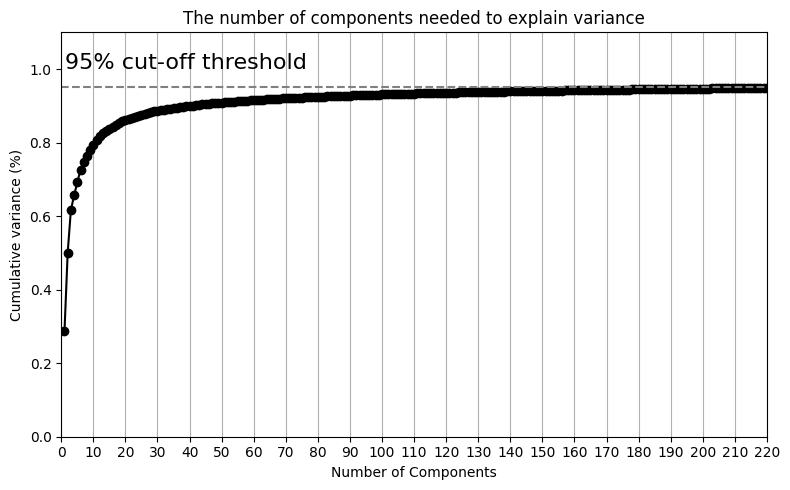

In [20]:
plt.rcParams["figure.figsize"] = (8, 5)

fig, ax = plt.subplots()
xi = np.arange(1, 8013, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker="o", linestyle="-", color="black")

plt.xlabel("Number of Components")
plt.xticks(np.arange(0, 8013, step=10))
plt.ylabel("Cumulative variance (%)")
plt.title("The number of components needed to explain variance")

plt.axhline(y=0.95, color="grey", linestyle="--")
plt.text(1.1, 1, "95% cut-off threshold", color="black", fontsize=16)
plt.xlim(0, 220)
ax.grid(axis="x")
plt.tight_layout();  # n_components = 150 explain 95% of variance

In [21]:
pca = PCA(n_components=150)  # Specify the number of components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [22]:
pd.DataFrame(X_train_pca).to_csv(
    ".\\DATA\\DataFrames\\X_train_pca.csv", index=False
)  # save X_train_pca
pd.DataFrame(X_test_pca).to_csv(
    ".\\DATA\\DataFrames\\X_test_pca.csv", index=False
)  # save X_test_pca

In [23]:
label_map = {
    v: k for k, v in images_data_keras.class_indices.items()
}  # #map numerical labels to string diagnoses

y_train_diagnosis = [label_map[label] for label in y_train]
y_test_diagnosis = [
    label_map[label] for label in y_test
]  # convert numerical labels to string diagnoses for y_train and y_test

y_train_diagnosis_df = pd.DataFrame(y_train_diagnosis, columns=["diagnosis"])
y_test_diagnosis_df = pd.DataFrame(y_test_diagnosis, columns=["diagnosis"])

y_train_diagnosis_df.to_csv(".\\DATA\\DataFrames\\y_train_diagnosis.csv", index=False)
y_test_diagnosis_df.to_csv(".\\DATA\\DataFrames\\y_test_diagnosis.csv", index=False)